In [1]:
from torchvision import datasets
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
dataset = datasets.MNIST('.', download=True)
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FCAD4834FA0>, 5)

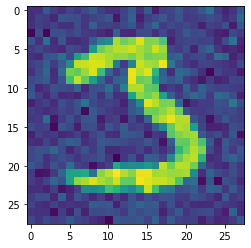

In [3]:
noized = dataset.data[11111].float() / 255 + torch.normal(
    torch.zeros_like(dataset.data[11111].float()), 
    0.1 * torch.ones_like(dataset.data[11111].float()))
plt.imshow(noized.detach().numpy())
plt.show()

In [4]:
# hyperparams
in_chan = 1
hidden_ch = 16
out_ch = 1
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

### AutoEncoder implementation

In [5]:
class AEncoder(nn.Module):
      # init 28x28 -> conv 24x24 -> pool 12 x 12 -> conv 10 x 10 -> 5 x 5 
    def __init__(self, in_chan, hidden_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_chan, hidden_ch, kernel_size=5) # 24 x 24
        self.pool1 = nn.MaxPool2d(2) # 12 x 12
        self.do1 = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(hidden_ch, 2*hidden_ch, kernel_size=3 ) # 10 x 10
        self.pool2 = nn.AvgPool2d(2) # 5 x 5
        self.do2 = nn.Dropout(0.1)
        self.conv3 = nn.Conv2d(2*hidden_ch, out_ch, kernel_size=3, stride=1 , padding=1 ) # 5 x 5
        self.activ = nn.Tanh()

    def forward(self, x):
        x = self.activ(self.do1(self.activ(self.pool1(self.conv1(x)))))
        x = self.activ(self.do2(self.activ(self.pool2(self.conv2(x)))))
        x = self.activ(self.conv3(x))
        return x

In [6]:
class ADecoder(nn.Module):
    # hidden_out-> conv 5 x 5 -> upsample 10 x 10 -> conv 14 x 14 -> upsample 28 x 28
    def __init__(self, in_chan, hidden_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(out_ch, 2*hidden_ch, kernel_size=3, stride=1, padding=1)
        self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 10 x 10
        self.conv2 = nn.Conv2d(2*hidden_ch, hidden_ch, kernel_size=5, stride=1, padding=4) # 14 x 14
        self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28
        self.conv3 = nn.Conv2d(hidden_ch, in_chan, kernel_size=3, stride=1, padding=1)
        self.activ = nn.Tanh()

    def forward(self, x):
        x = self.activ(self.upsample1(self.conv1(x)))
        x = self.activ(self.upsample2(self.conv2(x)))
        x = self.conv3(x)
        return x

In [7]:
class ConvAutoEncoder(nn.Module):
    def __init__(self, in_chan, hidden_ch, out_ch):
        super().__init__()
        self.encoder = AEncoder(in_chan, hidden_ch, out_ch)
        self.decoder = ADecoder(in_chan, hidden_ch, out_ch)

    def forward(self, x):
        hidden = self.encoder(x)
        x_ = self.decoder(hidden)

        return x_

In [8]:
def collate_fn_conv(data: list):

    pics = []
    target = []
    for item in data:
        pics.append(numpy.array(item[0]))
        target.append(item[1])
    pics = torch.from_numpy(numpy.array(pics)).float() / 255 
    target = torch.from_numpy(numpy.array(target))

    return {  'data': pics.unsqueeze(1), 
              'target': target.long(),
          }

In [9]:
model_cae = ConvAutoEncoder(in_chan, hidden_ch, out_ch).to(device)
optim = torch.optim.Adam(model_cae.parameters())
loss_func = nn.MSELoss()

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


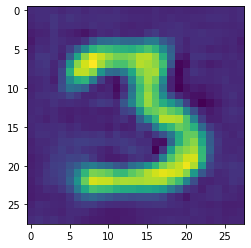

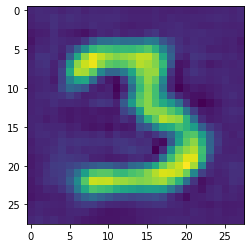

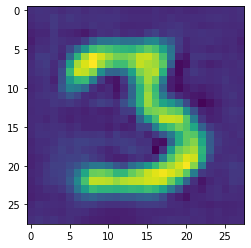

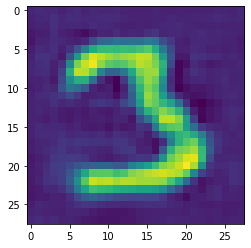

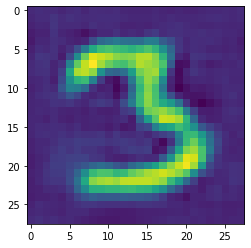

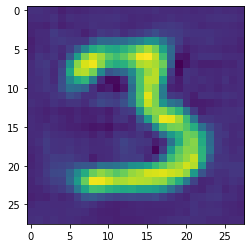

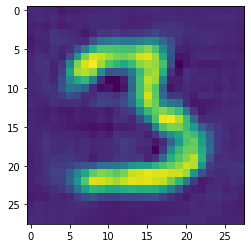

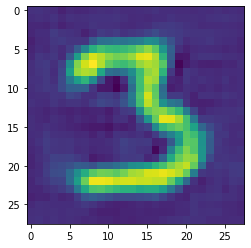

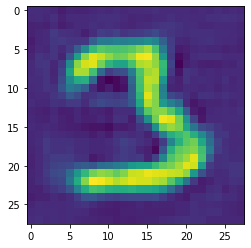

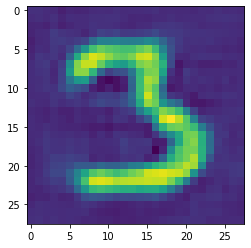

In [10]:
for epoch in range(n_epochs-8):
    dataloader = DataLoader(dataset, 
                            batch_size, 
                            shuffle=True, 
                            collate_fn=collate_fn_conv,
                            drop_last = True,
                            )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()
        data = batch['data'].to(device)
        predict = model_cae(data)
        loss = loss_func(predict, data)
        loss.backward()
        optim.step()
    if i % 200 == 0:
        print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset.data[11111].unsqueeze(0).unsqueeze(0).float()/255
    for i in range(5):
        plt.imshow(model_cae(item)[0].squeeze().cpu().detach().numpy())
        plt.show()
    torch.save(model_cae.state_dict(), f'./conv_ae_chkpt_conv_{epoch}.pth')

### VarAutoEncoder implementation

In [11]:
class Encoder(nn.Module):
      # init 28x28 -> conv 24x24 -> pool 12 x 12 -> conv 10 x 10 -> 5 x 5 
    def __init__(self, in_chan, hidden_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_chan, hidden_ch, kernel_size=5) # 24 x 24
        self.pool1 = nn.MaxPool2d(2) # 12 x 12
        self.do1 = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(hidden_ch, 2*hidden_ch, kernel_size=3 ) # 10 x 10
        self.pool2 = nn.AvgPool2d(2) # 5 x 5
        self.do2 = nn.Dropout(0.1)
        self.conv3 = nn.Conv2d(2*hidden_ch, 4*hidden_ch, kernel_size=3, stride=1 , padding=1 ) # 5 x 5
        self.activ = nn.Tanh()
        self.conv_mu = nn.Conv2d(4*hidden_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.conv_sigma = nn.Conv2d(4*hidden_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.activ = nn.Tanh()

    def forward(self, x):
        x = self.activ(self.do1(self.activ(self.pool1(self.conv1(x)))))
        x = self.activ(self.do2(self.activ(self.pool2(self.conv2(x)))))
        x = self.activ(self.conv3(x))
        mu = self.conv_mu(x)
        sigma = torch.exp(self.conv_sigma(x))
        return mu, sigma

In [12]:
class Decoder(nn.Module):
      # hidden_out-> conv 5x5 -> upsample -> 10x10 -> conv 14x14 -> upsample 28 x 28
    def __init__(self, in_chan, hidden_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(out_ch, 2*hidden_ch, kernel_size=3, stride=1, padding=1)
        self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 10 x 10
        self.conv2 = nn.Conv2d(2*hidden_ch, hidden_ch, kernel_size=5, stride=1, padding=4) # 14 x 14
        self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28
        self.conv3 = nn.Conv2d(hidden_ch, in_chan, kernel_size=3, stride=1, padding=1)
        self.activ = nn.Tanh()

    def forward(self, x):
        x = self.activ(self.upsample1(self.conv1(x)))
        x = self.activ(self.upsample2(self.conv2(x)))
        x = self.conv3(x)
        return x

In [13]:
def sampling(mu, sigma):
  norm = torch.normal(torch.zeros_like(sigma), torch.ones_like(sigma))
  return mu + sigma * norm

In [14]:
class ConvVarAutoEncoder(nn.Module):
    
    def __init__(self, in_chan, hidden_ch, out_ch):
        super().__init__()
        self.encoder = Encoder(in_chan, hidden_ch, out_ch)
        self.decoder = Decoder(in_chan, hidden_ch, out_ch)

    def forward(self, x):
        mu, sigma = self.encoder(x)
        hidden = sampling(mu, sigma)
        x_ = self.decoder(hidden)
        return x_, mu, sigma

In [15]:
def collate_fn_conv(data: list):
      # data = [(pic, target)...]
    pics = []
    target = []
    for item in data:
        pics.append(numpy.array(item[0]))
        target.append(item[1])
    pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
    target = torch.from_numpy(numpy.array(target))
    return {
            'data': pics.unsqueeze(1), # B x 1 x W x H
            'target': target.long(),
           }

In [16]:
model_conv = ConvVarAutoEncoder(in_chan, hidden_ch, out_ch).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.MSELoss()

def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(sigma))
    return torch.distributions.kl_divergence(p, q).mean()

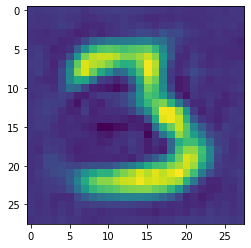

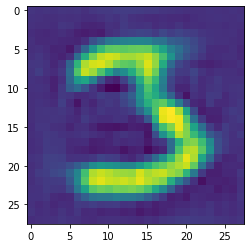

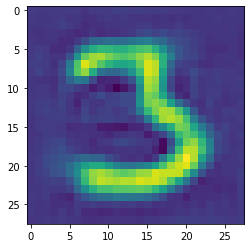

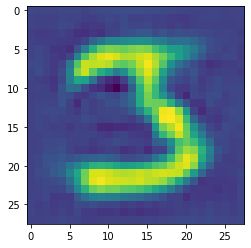

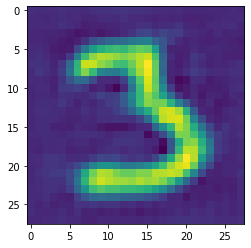

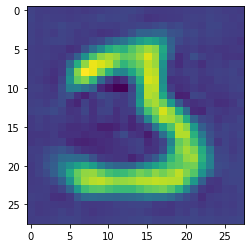

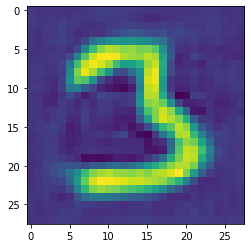

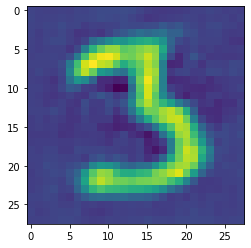

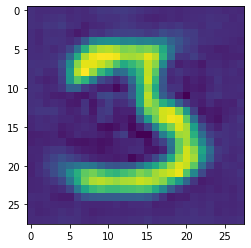

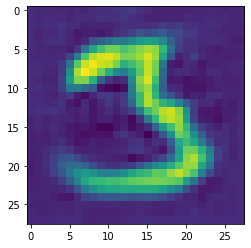

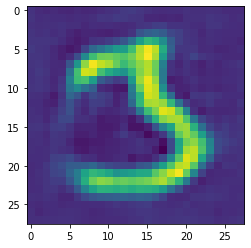

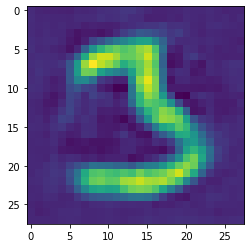

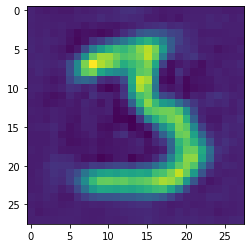

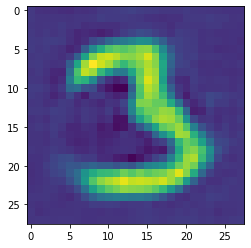

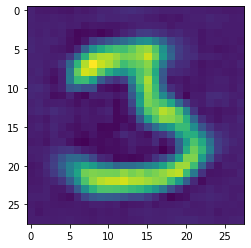

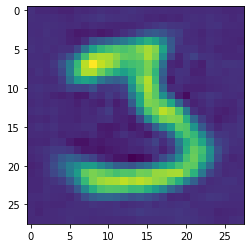

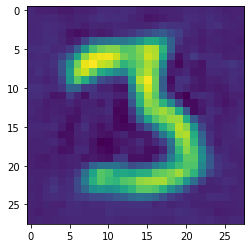

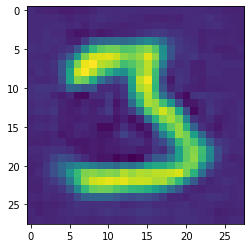

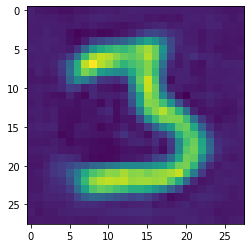

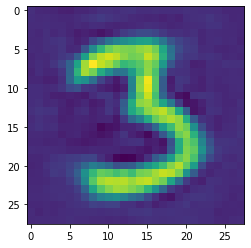

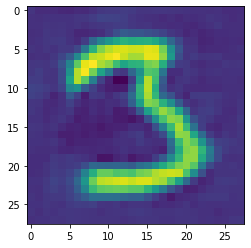

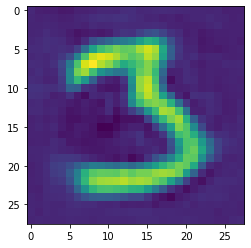

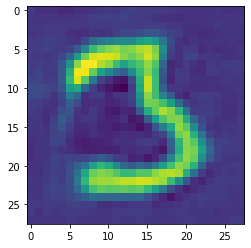

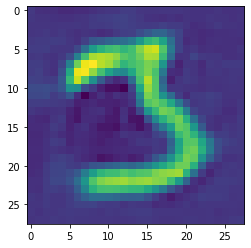

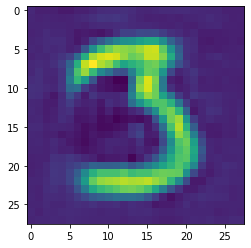

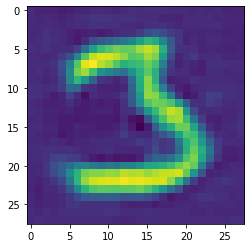

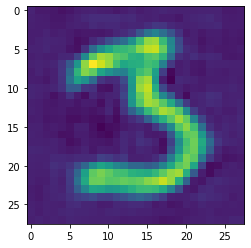

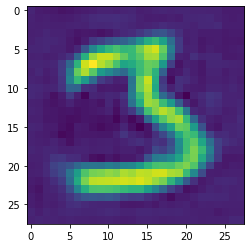

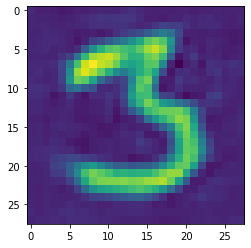

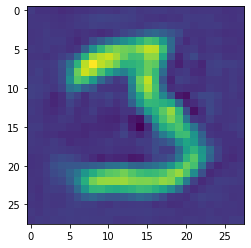

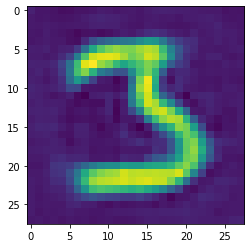

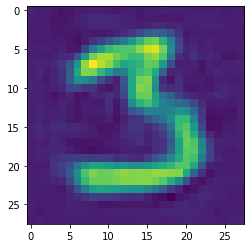

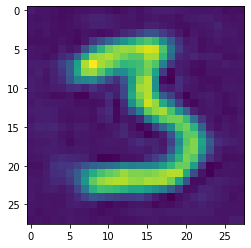

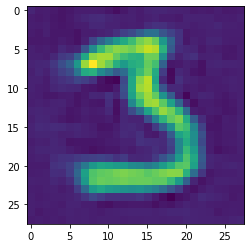

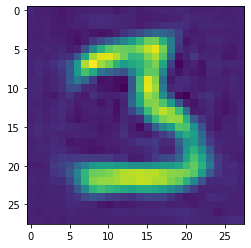

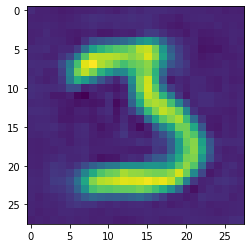

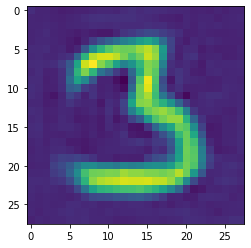

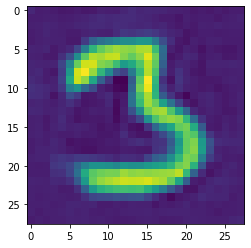

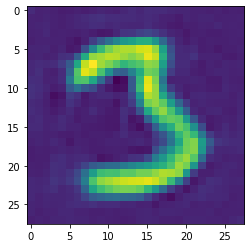

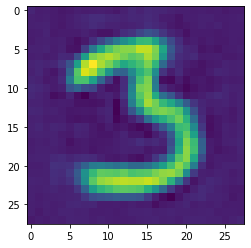

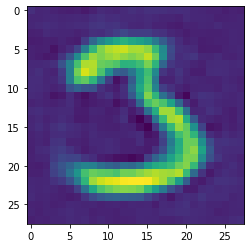

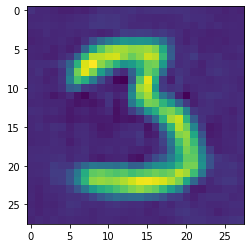

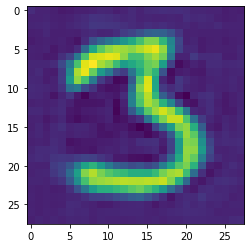

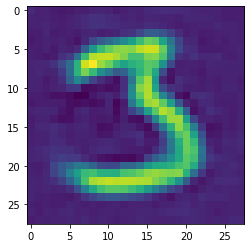

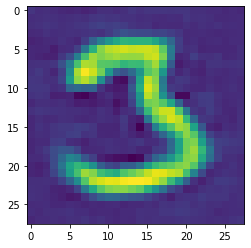

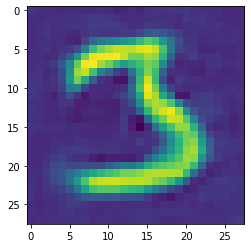

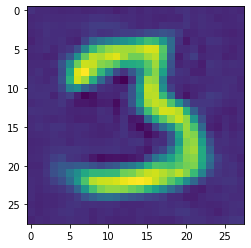

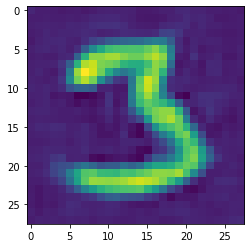

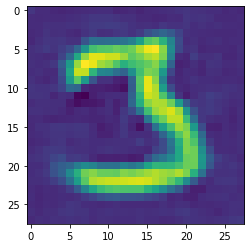

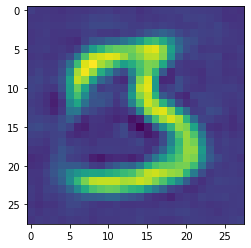

In [17]:
for epoch in range(n_epochs):
    dataloader = DataLoader(dataset, 
                            batch_size, 
                            shuffle=True, 
                            collate_fn=collate_fn_conv,
                            drop_last = True,
                            )
    for i, batch in enumerate(dataloader):
        optim.zero_grad()
        data = batch['data'].to(device)
        # noized = torch.clamp(data + torch.normal(torch.zeros_like(data), 
        #                                   noise_factor * torch.ones_like(data)), 0., 1.)
        predict, mu, sigma = model_conv(data)
        loss = loss_func(predict, data) + 0.01 * kl_loss(mu, sigma)
        loss.backward()
        optim.step()
    if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset.data[11111].unsqueeze(0).unsqueeze(0).float()/255
    mu, sigma = model_conv.encoder(item.to(device))
    # item = torch.normal(torch.zeros((1,1,7,7)), 3 * torch.ones((1,1,7,7)))
    for i in range(5):
        plt.imshow(model_conv.decoder(sampling(mu, sigma))[0].squeeze().cpu().detach().numpy())
        plt.show()
    torch.save(model_conv.state_dict(), f'./conv_ae_chkpt_conv_{epoch}.pth')